# Comparisions of recent bolo-calc run outputs

3 plots:  Psat, NET, and optical efficiency (all vs. band)

In [119]:
# Standard imports
import os.path
import pprint
import numpy as np

import yaml
import deepdiff
import toml

import matplotlib
import matplotlib.pyplot as plt

%pprint
%matplotlib inline  
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 6]

Pretty printing has been turned ON


## Define generic plotting routine

In [98]:
def plotxy(model, xname, yname, ptype, semilogy=False):
    xvec = {'SAT':np.array([]) }
    yvec = {'SAT':np.array([]) }

    for key1 in [key for key, value in model.items() if 'yaml' in key.lower()]:
        tel = key1.split('_')[0]
        for key2 in model[key1]:
            if key2 != 'defaults':
                xvec[tel] = np.append(xvec[tel], model[key1][key2][xname])
                yvec[tel] = np.append(yvec[tel], model[key1][key2][yname])

    for tel in xvec.keys():
        if semilogy:
            plt.semilogy(xvec[tel], yvec[tel], ptype[tel][1],  label=ptype[tel][0], markersize=12)
        else:
            plt.plot(xvec[tel], yvec[tel], ptype[tel][1], label=ptype[tel][0], markersize=12)
    return xvec,yvec


# Select the inputs and load the files

In [99]:
# Enter the models to be compared as "dirname":{"label":<label>, "date":<date of run>}

models = {
    'pbdr_v3':{
        "label":"PBDR v3", 
        "date" :"10/2021"
    },
    'pbdr_v4':{
        "label":"PBDR v4",
        "date" :"05/2022"
    }
}

## Build a set of models to compare

In [106]:
yaml_sets = {}
model_keys = list(models.keys()) # Get a list of models in known order - shouldn't be necessary in Python>=3.7

for m in model_keys:
    model = toml.load(f"{m}/outputs/BaseModel.toml")
    models[m]["outputs"] = model
    models[m]["inputs"] = []
    
    for key in model.keys(): 
        if 'yaml' in key.lower():
            tel = key.split('_')[0]
            cam = key.split('_')[1]
            # assumes that only the last part of the yaml name is a date/contains the variation details
            yaml_root = "_".join(key.split('_')[:-1])
            
            if yaml_root in yaml_sets.keys():
                yaml_sets[yaml_root].append(os.path.join(m, key))
            else:
                yaml_sets[yaml_root] = [os.path.join(m, key)]
            
            for key2 in model[key]:
                # key2 is the channel name
                if key2 != 'defaults':
                    chan = key2

In [121]:
pprint.pprint(yaml_sets)

{'SAT_HF': ['pbdr_v3\\SAT_HF_20210714.yaml', 'pbdr_v4\\SAT_HF_20220524.yaml'],
 'SAT_LF': ['pbdr_v3\\SAT_LF_20211015.yaml', 'pbdr_v4\\SAT_LF_20220524.yaml'],
 'SAT_MF': ['pbdr_v3\\SAT_MF_20211015.yaml', 'pbdr_v4\\SAT_MF_20220524.yaml']}


# Compare the model inputs

In [132]:
# Assumes that the first model is the base to compare others to
for y in yaml_sets.keys():
    print()
    print(y)
    base_yaml = yaml_sets[y][0]
    base = yaml.safe_load(open(base_yaml))
    var_yamls = yaml_sets[y][1:]
    variations = []
    for v_yaml in var_yamls:
        var = yaml.safe_load(open(v_yaml))
        variations.append(var)
    
        print(f"Comparing {base_yaml} to {v_yaml}")
        diff = deepdiff.DeepDiff(base, var, view='tree')
        print(diff.pretty())
    


SAT_LF
Comparing pbdr_v3\SAT_LF_20211015.yaml to pbdr_v4\SAT_LF_20220524.yaml
Value of root['version']['date'] changed from 20211015 to 20220524.
Value of root['instrument']['optics_config']['elements']['lens1']['thickness'] changed from 0.055 to 0.057.
Value of root['instrument']['optics_config']['elements']['lens2']['thickness'] changed from 0.059 to 0.048.

SAT_MF
Comparing pbdr_v3\SAT_MF_20211015.yaml to pbdr_v4\SAT_MF_20220524.yaml
Value of root['version']['date'] changed from 20211015 to 20220524.
Value of root['instrument']['optics_config']['elements']['lens1']['thickness'] changed from 0.055 to 0.057.
Value of root['instrument']['optics_config']['elements']['lens2']['thickness'] changed from 0.059 to 0.048.

SAT_HF
Comparing pbdr_v3\SAT_HF_20210714.yaml to pbdr_v4\SAT_HF_20220524.yaml
Item root['instrument']['optics_config']['elements']['ApStop'] added to dictionary.
Item root['instrument']['optics_config']['elements']['aperture'] removed from dictionary.
Value of root['versio

# Plot Psat vs band center, for all wafer types.

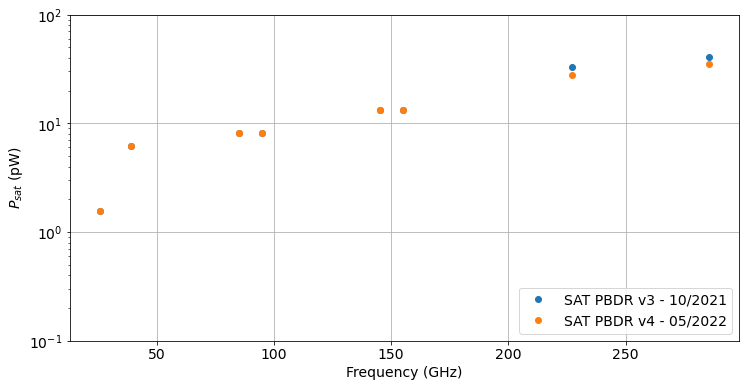

In [130]:
for key in models.keys():
    label = f"{models[key]['label']} - {models[key]['date']}"
    ptype =  {'SAT' : [f'SAT {label}', "."]}
    outs = plotxy(models[key]["outputs"], 'bandcenter', 'psat', ptype, semilogy=True)

plt.xlabel('Frequency (GHz)')
plt.ylabel('$P_{sat}$ (pW)')
plt.legend(loc="lower right")
plt.ylim(0.1,100)
plt.grid()

# Plot NET vs band center, for all wafer types.

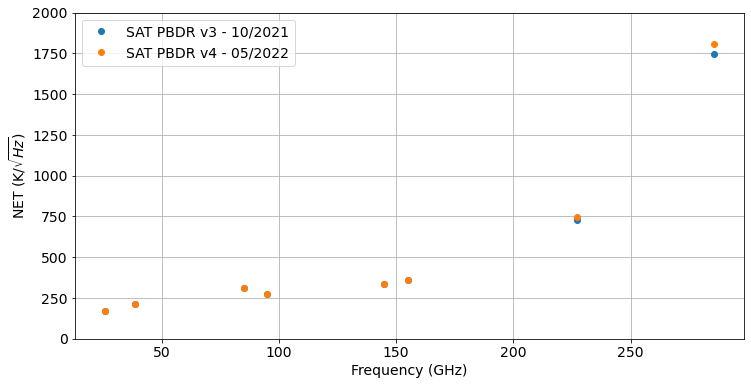

In [125]:
for key in models.keys():
    label = f"{models[key]['label']} - {models[key]['date']}"
    ptype =  {'SAT' : [f'SAT {label}', "."]}
    outs = plotxy(models[key]["outputs"], 'bandcenter', 'net', ptype)

plt.xlabel('Frequency (GHz)')
plt.ylabel('NET (K/$\sqrt{Hz}$)')
plt.legend(loc="upper left")
plt.ylim(0,2000)
plt.grid()




Plotting


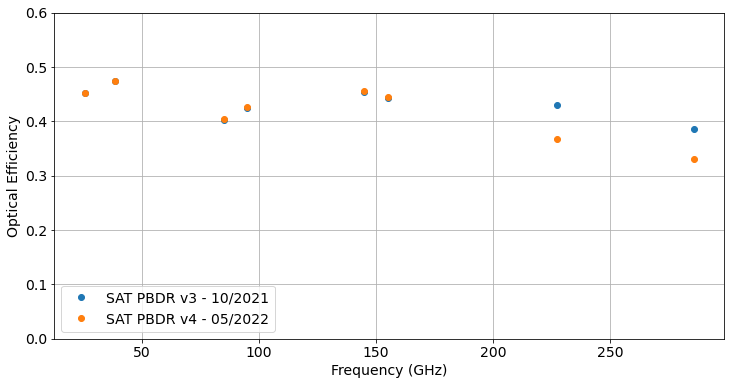

In [127]:
for key in models.keys():
    label = f"{models[key]['label']} - {models[key]['date']}"
    ptype =  {'SAT' : [f'SAT {label}', "."]}
    outs = plotxy(models[key]["outputs"], 'bandcenter', 'effic', ptype)

plt.xlabel('Frequency (GHz)')
plt.ylabel('Optical Efficiency')
plt.legend(loc="lower left")
plt.ylim(0,0.6)
plt.grid()